# 브랜드 로고 예측하기 _ DNN (허채범)

In [793]:
# 모듈 로딩
from urllib.request import urlopen,Request,urlretrieve
from bs4 import BeautifulSoup
from selenium import webdriver
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow.keras import Sequential, models, layers, regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

## * 이미지 회전 시키기 => 데이터 증식

In [794]:
# 크롤링 데이터 로테이션시키는 함수
def rota_save(color,foldname):
    # 폴더 만들기
    if not os.path.exists('./'+foldname):
        os.makedirs(foldname)
    
    rotation=[45,90,135,180,225,270,315]    # 로테이션 각도 (7가지)
    for file in os.listdir('./data/'):
        for rot in rotation:
            img=np.array(Image.open('./data/'+file).convert(color))
            rows,cols = img.shape[0:2]
            ro_mt = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1.42)
            ro_img = cv2.warpAffine(img, ro_mt,(cols, rows))
            
            # 이미지 저장
            filename=f"{file}_ro{str(rot)}"
            cv2.imwrite('./'+foldname+'/'+filename+'.png',ro_img)

In [795]:
# 크롤링 데이터 convert 함수
def data_con(color,foldname):
    for file in os.listdir('./data/'):
        img=Image.open('./data/'+file).convert(color).save('./'+foldname+'/'+file)

In [796]:
# 흑백으로 로테이션
rota_save('L','blwh')

# rgb로 로테이션
rota_save('RGB','rgb')

# 원본사진 흑백으로
data_con('L','blwh')

# 원본사진 색깔로
data_con('RGB','rgb')

## * 사진 데이터화 시키기

In [797]:
# 사진 데이터화 시키기
def transD(foldname):
    l=[]
    for i in os.listdir('./'+foldname+'/'):
        n=np.array(Image.open('./'+foldname+'/'+i))/255.0
        if foldname=='blwh':
           n_list=n.reshape(-1,50*50)[0].tolist()
        else:
            n_list=n.reshape(-1,50*50*3)[0].tolist()
        l.append(n_list)
    return np.array(l)

In [798]:
# 전체 이미지 데이터화 (흑백)
blwh=transD('blwh')

# 전체 이미지 데이터화 (컬러)
rgb=transD('rgb')

# 이미지 확인
# plt.imshow(blwh[3500].reshape(50,50,), cmap='gray')
# plt.imshow(rgb[3500].reshape(50,50,3), cmap='gray')

## * input / target data 만들기

In [799]:
# input data
X1 = blwh  # 흑백
X2 = rgb   # 컬러

In [800]:
# target data
label = pd.read_csv('target.csv')
y = np.array(label.label)
y

array([ 0,  0,  0, ..., 25, 25, 25], dtype=int64)

## * 데이터 분리
---

In [801]:
# 크롤링해서 받을 때 이미 /255.0을 해 준 상태 (0~1) 사이로 바뀌어 있음
# 데이터가 적으므로 train, test 데이터만 분리
X_train, X_test, y_train, y_test = train_test_split(X2, y, 
                                                    stratify = y,
                                                    random_state=42, test_size=0.35)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
#                                                   stratify = y_train,
#                                                   random_state=42, test_size=0.2)

In [802]:
# 이미 함수로 /255.0을 해서 0~1 사이에 있는 상태
# reshape로 1차원으로 다 바뀌어져 있는 상태

print(f'X_train.shape : {X_train.shape}')  # 학습용
print(f'X_test.shape  : {X_test.shape}')   # 테스트용
print(f'y_train.shape : {y_train.shape}')
print(f'y_test.shape  : {y_test.shape}')

X_train.shape : (2802, 7500)
X_test.shape  : (1510, 7500)
y_train.shape : (2802,)
y_test.shape  : (1510,)


# [ DNN ]

## [1] 모델 구성 및 생성
---

In [803]:
# 노드 수 조절하도록 모델 만드는 함수
def createModel(n_node):
    model = Sequential(name='snackBrand')
    model.add( Dense(units=n_node, activation = 'relu', input_shape=(7500,)) )
    model.add( BatchNormalization() )
    model.add( Dense(300, activation = 'relu') )
    
    # model.add( Dense(500, activation = 'relu', kernel_regularizer = regularizers.l2(0.00001)) )
    # Input data는 정규분포라고 하더라도 레이어를 거치고나면 정규분포가 아닐 수도 있음
    # -> data를 정규화하여 활성화 함수를 통과하게 한다.
    
    model.add( Dense(300, activation = 'relu') )
    model.add( Dense(300, activation = 'relu', kernel_regularizer = regularizers.l2(0.00001)) )
    model.add( Dense(300, activation = 'relu') )
    model.add( Dense(300, activation = 'relu', kernel_regularizer = regularizers.l2(0.00001)) ) 
    model.add( Dropout(0.2) )
    
#     model.add( Dense(500, activation = 'relu') )
#     model.add( Dense(500, activation = 'relu') )
#     model.add( Dense(250, activation = 'relu') )
#     model.add( Dropout(0.2) )
    
    model.add( Dense(100, activation = 'relu') )
    model.add( Dense(26, activation = 'softmax') )
    model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics='accuracy')
    return model

In [804]:
Model1 = createModel(100)
Model2 = createModel(300)
Model3 = createModel(500)

## [2] 모델 확인
---

In [805]:
# Model1.summary()
# print('\n\n')
# Model2.summary()
# print('\n\n')
Model3.summary()

Model: "snackBrand"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_809 (Dense)           (None, 500)               3750500   
                                                                 
 batch_normalization_75 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                                 
 dense_810 (Dense)           (None, 300)               150300    
                                                                 
 dense_811 (Dense)           (None, 300)               90300     
                                                                 
 dense_812 (Dense)           (None, 300)               90300     
                                                                 
 dense_813 (Dense)           (None, 300)               90300     
                                                        

## [2-1] 모델 시각화
---

In [806]:
from tensorflow.keras.utils import plot_model
# plot_model(Model3, show_shapes=True)

## [3] 학습

In [807]:
Model3.fit(X_train, y_train, epochs=30)#, verbose=False)

Epoch 1/30
88/88 [==============================] - 3s 17ms/step - loss: 2.8719 - accuracy: 0.1463
Epoch 2/30
88/88 [==============================] - 1s 17ms/step - loss: 2.4690 - accuracy: 0.2370
Epoch 3/30
88/88 [==============================] - 1s 17ms/step - loss: 2.1932 - accuracy: 0.3062
Epoch 4/30
88/88 [==============================] - 1s 17ms/step - loss: 2.0071 - accuracy: 0.3822
Epoch 5/30
88/88 [==============================] - 1s 17ms/step - loss: 1.8457 - accuracy: 0.4154
Epoch 6/30
88/88 [==============================] - 1s 17ms/step - loss: 1.7253 - accuracy: 0.4572
Epoch 7/30
88/88 [==============================] - 1s 17ms/step - loss: 1.6197 - accuracy: 0.4836
Epoch 8/30
88/88 [==============================] - 1s 16ms/step - loss: 1.4659 - accuracy: 0.5310
Epoch 9/30
88/88 [==============================] - 1s 17ms/step - loss: 1.4073 - accuracy: 0.5314
Epoch 10/30
88/88 [==============================] - 1s 16ms/step - loss: 1.3631 - accuracy: 0.5600
Epoch 11/

## [4] 평가

In [808]:
# 수차례 조정을 거치면서
# -> 과적합이 감소되지는 않았으나, train과 test의 정확도가 동시에 올라가는 경우가 많았음
Model3.evaluate(X_train, y_train)
Model3.evaluate(X_test, y_test)

48/48 [==============================] - 0s 4ms/step - loss: 1.8026 - accuracy: 0.5682


[1.8026303052902222, 0.5682119131088257]

## [5] 예측

In [809]:
predicted = Model3.predict(X_test)

48/48 [==============================] - 0s 4ms/step


### [5-1] 정답확인 (테스트셋)

In [810]:
# 1) 정답지 DF로 만들기
label = pd.read_csv('target.csv')
df = pd.DataFrame(label.name.unique())
df['label'] = label.label.unique()
df.columns = ['Brand', 'Label']
# df

In [811]:
# 2) X_test와 그 결과(y_test)
# for i in range(len(X_test)):
for i in range(9):
    print(f'X_test ' + str(i) + f' : {predicted[i].argmax()}')
    print(f'y_test ' + str(i) + f' : {y_test[i]}')
    print(f"{df[df['Label'] == y_test[i]]}\n")

X_test 0 : 8
y_test 0 : 8
    Brand  Label
8  domino      8

X_test 1 : 9
y_test 1 : 0
       Brand  Label
0  angelinus      0

X_test 2 : 18
y_test 2 : 18
   Brand  Label
18  orin     18

X_test 3 : 18
y_test 3 : 20
       Brand  Label
20  pizzahut     20

X_test 4 : 7
y_test 4 : 7
   Brand  Label
7  debec      7

X_test 5 : 25
y_test 5 : 25
           Brand  Label
25  twosomeplace     25

X_test 6 : 22
y_test 6 : 14
    Brand  Label
14  lotte     14

X_test 7 : 8
y_test 7 : 10
       Brand  Label
10  galleria     10

X_test 8 : 2
y_test 8 : 2
         Brand  Label
2  bbackdabang      2



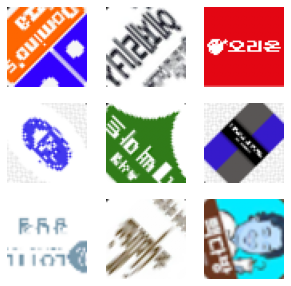

In [812]:
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(50,50,3))
    plt.axis("off")    

1/1 [==============================] - 0s 80ms/step

새로운 이미지의 라벨값 : 22

        Brand  Label
22  shinsegae     22



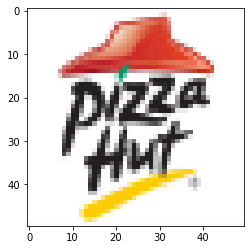

In [813]:
# 새로운 이미지 데이터로 예측해보기
import PIL.Image as pilimg

# 테스트하기 위한 새로운 이미지 파일
n = 7

# [5,6,7,8 ...]

# 이미지 열기 및 변환
img = np.array(pilimg.open('./testImg/test'+str(n)+'.png').convert('RGB'))
%matplotlib inline 
plt.imshow(img)

# 새로운 이미지 predict
preTest = Model3.predict(img.reshape(-1, 50*50*3))  # reshape해주는 array 체크
print('\n새로운 이미지의 라벨값 : {}'.format(preTest.round(2).argmax()))
preTest_num = preTest.round(2).argmax()

# 새로운 이미지 정답
print(f"\n{df[df['Label'] == preTest_num]}\n")
# print(f"{df[df['Label'] == n]}\n")

## T^T

In [814]:
# # 새로운 이미지 데이터로 예측해보기
# import PIL.Image as pilimg
# for filename in os.listdir('./testImg/'):
#     img = np.array(pilimg.open(filename).convert('RGB'))
    
#     %matplotlib inline 
#     plt.imshow(img)
    
#     plt.figure(figsize=(10, 10))
# #     augmented_image = data_augmentation(image)
#     ax = plt.subplot(4, 5, i + 1)
#     plt.imshow(img)
#     plt.axis("off")

In [815]:
# # 예측 함수
# def pred_(file_name):
#     im=Image.open(file_name)
#     im=np.array(im.resize((50,50)))/255.0
#     pre_y=model.predict(im.reshape(-1,50*50*3))
# #     idx=np.argmax(np.round(pre_y,2))
#     plt.imshow(im)
#     return 

# [ AutoEncoder ]

## [2] 모델 구성 및 생성
---

In [816]:
model = tf.keras.Sequential([
    layers.Dense(units=300, activation='relu', input_shape=(7500,)),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(7500, activation='sigmoid')
])

In [817]:
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics='accuracy')

## [3] 모델 확인 및 시각화
---

In [818]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_817 (Dense)           (None, 300)               2250300   
                                                                 
 dense_818 (Dense)           (None, 500)               150500    
                                                                 
 dense_819 (Dense)           (None, 500)               250500    
                                                                 
 dense_820 (Dense)           (None, 7500)              3757500   
                                                                 
Total params: 6,408,800
Trainable params: 6,408,800
Non-trainable params: 0
_________________________________________________________________


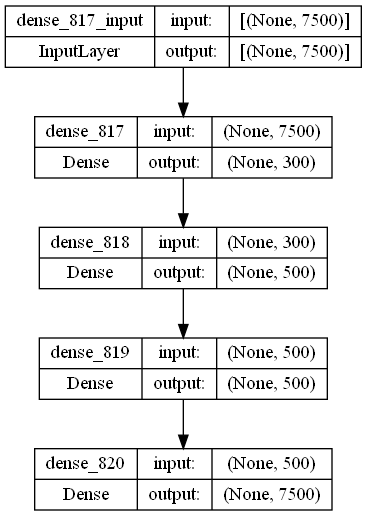

In [819]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## [4] 학습
---

In [820]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
88/88 [==============================] - 3s 29ms/step - loss: 200.5725 - accuracy: 0.0585
Epoch 2/30
88/88 [==============================] - 2s 27ms/step - loss: 200.3162 - accuracy: 0.0632
Epoch 3/30
88/88 [==============================] - 3s 30ms/step - loss: 200.3162 - accuracy: 0.0632
Epoch 4/30
88/88 [==============================] - 3s 31ms/step - loss: 200.3162 - accuracy: 0.0632
Epoch 5/30
88/88 [==============================] - 3s 29ms/step - loss: 200.3162 - accuracy: 0.0632
Epoch 6/30
45/88 [==============>...............] - ETA: 1s - loss: 197.9826 - accuracy: 0.0660

KeyboardInterrupt: 

## [5] 평가
---

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

## [6] 예측
---

In [ ]:
predicted = model.predict(X_test)

### [6-1] 정답확인 (테스트셋)
---

In [ ]:
# 1) 정답지 DF로 만들기
label = pd.read_csv('target.csv')
df = pd.DataFrame(label.name.unique())
df['label'] = label.label.unique()
df.columns = ['Brand', 'Label']
df

In [ ]:
# 2) X_test와 그 결과(y_test)
# for i in range(len(X_test)):
for i in range(1,9):
    print(f'X_test ' + str(i) + f' : {predicted[i].argmax()}')
    print(f'y_test ' + str(i) + f' : {y_test[i]}')
    print(f"{df[df['Label'] == y_test[i]]}\n")

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(1,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(50,50,3))
    plt.axis("off")    

In [ ]:
img=np.array(pilimg.open('./testImg/test1.png').convert('RGB'))
# img.reshape(50*50*3,).shape
preTest = model.predict(img.reshape(50*50*3,))
# preTest.round(2), preTest.shape